# Time Series

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

In [2]:
y_train = pd.read_csv("y_train.txt", header=None, delim_whitespace=True )
body_gyro_z_train = pd.read_csv("body_gyro_z_train.txt", header=None,  delim_whitespace=True)
body_gyro_z_test = pd.read_csv("body_gyro_z_test.txt", header=None,  delim_whitespace=True)

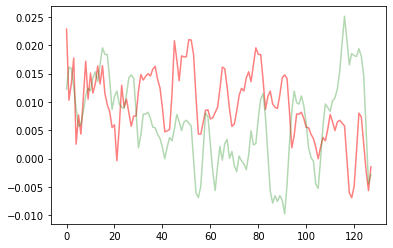

In [4]:
#Fare la trasposta per avere il dataset in cui le colonne sono i timestamp
ts0 = body_gyro_z_train.T[0]
ts1 = body_gyro_z_train.T[1]

plt.plot(ts0, color='r', alpha=0.5)
plt.plot(ts1,color='g', alpha=0.3)
plt.show()

## Trasformation

### Transformation I: Offset Translation

In [ ]:
ts_offs=body_gyro_z_train.copy(deep=True)

In [ ]:
#ts_off=[]
for i in range(0,7352,1):
    ts_offs.T[i] = (ts_offs.T[i] - ts_offs.T[i].mean())

plt.plot(ts_offs.T[0])
plt.plot(ts_offs.T[1])
plt.plot(body_gyro_z_train.T[0])
plt.show()

### Transformation II: Amplitude Scaling

In [ ]:
ts_ampl=body_gyro_z_train.copy(deep=True) #copio il dataframe senza modificare l'originale per poi salvare l'amplitude Scaling

In [ ]:
for i in range(0,7352,1):
    ts_ampl.T[i]=(ts_ampl.T[i] - ts_ampl.T[i].mean())/ts_ampl.T[i].std()

plt.plot(ts_ampl.T[0])    
plt.plot(body_gyro_z_train.T[0]) #in arancione, i suoi valori erano nell'intorno dello 0 e ora sono molto amplificati
plt.show()

In [ ]:
plt.plot(ts_ampl.T[0]) #blu
plt.plot(ts_ampl.T[4]) #arancione
plt.show()

### Transformation IV: Noise (smoothing)


In [5]:
ts_noismot = body_gyro_z_train.copy(deep=True)

In [6]:
w_noise=10 # regola la rimozione del rumore NB! forse va calibrato in base alle pause spiegate nelle feature info??
#ts_noise=[] 
for i in range(0,7352,1):
    ts_noismot.T[i] = ((ts_noismot.T[i].mean())/(ts_noismot.T[i].std()).rolling(window=10).mean())
    #ts_noise.append(((ts[i]- ts[i].mean())/ts[i].std()).rolling(window=w_noise).mean())
plt.plot(ts_ampl[0])
plt.plot(ts_noismot[0])
plt.show()

AttributeError: 'float' object has no attribute 'rolling'

In [7]:
plt.plot(ts_noise[0])
plt.plot(ts_noise[1])
plt.show()

NameError: name 'ts_noise' is not defined

### Transformation III: Trend removal

In [ ]:
ts_trend = body_gyro_z_train.copy(deep=True) #NON CONVIENE UTILIZZARLO PERCHE' LASCIA TROPPI NAN

In [ ]:
#ts_shift=[]
for i in range(0,7352,1):    # calcola il rolling e prende la media per usarla come trend
    ts_trend.T[i] = ts_trend.T[i] - ts_trend.T[i].rolling(window=12).mean()
    #ts_shift.append(ts[i] - ts[i].rolling(window=12).mean()) # rimuove il trend
plt.plot(ts_trend.T[0])
plt.plot(ts_trend.T[1])
plt.show()

In [ ]:
plt.plot(ts_shift[0])
plt.plot(ts_shift[1])
plt.show()

## Features Extraction

In [ ]:
#SE DAL DATASET DELLE TIMESERIES VOGLIAMO LAVORARE CON LE FATURES:

import numpy as np
import scipy.stats as stats

from tsfresh.feature_extraction import extract_features # non riesco ad installare tsfresh, quindi non mi funziona
from tsfresh.feature_extraction import ComprehensiveFCParameters

In [ ]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [ ]:
features = calculate_features(ts[0])
features

In [ ]:
body_acc_x_train['id'] = [0] * len(body_acc_x_train) # crea un id altimenti non  gli funziona # non so se a noi serve

In [ ]:
settings = ComprehensiveFCParameters()
del settings['matrix_profile']

In [ ]:
## per estrarre una serie di features preimpostate
features = extract_features(timeseries_container=body_acc_x_train, 
                            column_id='id', 
                            default_fc_parameters=settings)

In [ ]:
features.to_dict() # calcola features # attento molte sono null

## Approximations (TS Dimensionality_Reduction)

### Trasformazione di Fourier

In [ ]:
from pyts.approximation import DiscreteFourierTransform # consigliata se la Time Series presenta una forma naturale, altrimenti usi la PAA

In [ ]:
n_coefs = 64 
ts_off1=pd.DataFrame(ts_off)
dft = DiscreteFourierTransform(n_coefs=n_coefs)
ts1_dft = dft.fit_transform(ts_off1.values.reshape(1, -1)) # trasforma da una colonna a una riga e 64 colonne

In [ ]:
ts1_dft = pd.DataFrame(ts1_dft)
ts1_dft

In [ ]:
#Inverse Transform
ts1_dft_inv = dft_inverse_trasform(ts1_dft, n_coefs=n_coefs, n_timestamps=len(ts1.values))
ts1_dft_inv

In [ ]:
plt.plot(ts1_dft.ravel()) # timeseries dopo la trasformazione di fourier ma prima di fare l'inverso
plt.show

In [ ]:
plt.plot(ts1.ravel()) # originale
plt.plot(ts1_dft_inv.ravel()) # dopo l'approssimazione di Fourier invertita
plt.show()

### Trasformazione SVD

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
svd = TruncatedSVD(n_components=2) # numero di componenti che gli passi
ts1_svd = svd.fit_transform(ts1.values.reshape(1, -1))
#ts_svd = svd.fit_transform(np.array([ts.values.reshape(1, -1)[0], 
#                                     ts.values.reshape(1, -1)[0]]))

In [ ]:
ts1_svd_inv = svd.inverse_transform(ts1_svd)[0]
ts1_svd_inv

In [ ]:
plt.plot(ts1.ravel()) # per una sigola time series ottieni una sovrapposizione perfetta

plt.plot(ts1_svd_inv.ravel())
plt.show()

## -- Più utilizzate --

### PieceAggregateApproximation (PAA)

In [ ]:
from tslearn.piecewise import PiecewiseAggregateApproximation # Questa è consigliata se la TS non ha una forma naturale, altrimenti usi la Trasformazione di Fourier
from tslearn.piecewise import SymbolicAggregateApproximation
from tslearn.piecewise import OneD_SymbolicAggregateApproximation 
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [ ]:
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series # Normalizza una riga
ts0 = body_acc_x_train.T[0]
ts1 = body_acc_x_train.T[1]
ts2 = body_acc_x_train.T[2]

ts0 = scaler.fit_transform(ts0.values.reshape(1,-1))
ts1 = scaler.fit_transform(ts1.values.reshape(1,-1))
ts2 = scaler.fit_transform(ts2.values.reshape(1,-1))

In [ ]:
# PAA transform (and inverse transform) of the data
n_paa_segments = 10                                         # sarebbe quella che nelle slides chiama "N" ( e a lezione"k")
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
ts0_paa = paa.fit_transform(ts0)                              # fit transform
paa_dataset_inv = paa.inverse_transform(ts0_paa)             # inverse transform

In [ ]:
plt.plot(ts0_paa.ravel(), marker='o')  # se ha un andamento decrescente ci fa capire che ha un trend decrescente
plt.show()                             # se ha un andamento crescente ci fa capire che ha un trend crescente
                                        # i punti rappresentano i valori medio dei 10 punti (n_paa_segments) che approssimano
                                        # la time series

In [ ]:
plt.plot(paa_dataset_inv.ravel()) # qui vediamo la l'inverse trasformation e ogni box
plt.show()                     # ogni box ha come valore quelli dati da print(ts0_paa)

In [ ]:
# Se sovrapponiamo alla precedente, l'originale
plt.plot(paa_dataset_inv.ravel()) # qui vediamo la l'inverse trasformation e ogni box # questa è la ricostruzione dopo la compressione
plt.plot(ts0.ravel()) # l'originale
plt.show()

### Symbolic Aggregate Approximation (SAX)

In [ ]:
ts= body_gyro_z_train.copy(deep=True)
ts.T[1] #con la trasposta vado a considerara l'intera riga, Serie Temp.

In [ ]:
#normalizz
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series # Normalizza una riga
ts_norm = scaler.fit_transform(ts)
ts_norm.shape

In [ ]:
#SAX
n_sax_symbols = 4
sax = SymbolicAggregateApproximation(n_segments=32,  #numero di segmenti
                                     alphabet_size_avg=n_sax_symbols) # parametro grandezza alfabeto
ts_sax_norm=sax.fit_transform(ts_norm)
ts_sax_inv = sax.inverse_transform(ts_sax_norm)

In [ ]:
plt.plot(ts_norm[0], label='grezza')
plt.plot(ts_sax_inv[0], label='SAX')
plt.legend(loc='best')
plt.show

In [ ]:
# mostro differenza tra PAA e SAX
plt.plot(paa_dataset_inv.ravel())
plt.plot(sax_dataset_inv.ravel()) # nota ogni segmento del PAA corrisponde a un numero di SAX (perché abbaimo usato lo stesso numero di componenti)
plt.show()

In [ ]:
plt.figure()
plt.subplot(2, 2, 1)  # First, raw time series
plt.plot(ts0[0].ravel(), "b-")
plt.title("Raw time series")

plt.subplot(2, 2, 2)  # Second, PAA
plt.plot(ts0[0].ravel(), "b-", alpha=0.4)
plt.plot(paa_dataset_inv[0].ravel(), "b-")
plt.title("PAA")

plt.subplot(2, 2, 3)  # Then SAX
plt.plot(ts0[0].ravel(), "b-", alpha=0.4)
plt.plot(sax_dataset_inv[0].ravel(), "b-")
plt.title("SAX, %d symbols" % n_sax_symbols)

plt.subplot(2, 2, 4)  # Finally, 1d-SAX
plt.plot(ts0[0].ravel(), "b-", alpha=0.4)
plt.plot(one_d_sax_dataset_inv[0].ravel(), "b-")
plt.title("1d-SAX, %d symbols"
          "(%dx%d)" % (n_sax_symbols_avg * n_sax_symbols_slope,
                       n_sax_symbols_avg,
                       n_sax_symbols_slope))

plt.tight_layout()
plt.show()

#### PAA vs SAX

In [ ]:
# PAA

ts1_paa = paa.fit_transform(ts1)
ts2_paa = paa.fit_transform(ts2)

In [ ]:
plt.plot(paa.inverse_transform(ts1_paa)[0].ravel())
plt.plot(paa.inverse_transform(ts2_paa)[0].ravel())
plt.show()

In [ ]:
# SAX

ts1_sax = sax.fit_transform(ts1)
ts2_sax = sax.fit_transform(ts2)

In [ ]:
plt.plot(sax.inverse_transform(ts1_sax)[0].ravel())
plt.plot(sax.inverse_transform(ts2_sax)[0].ravel())
plt.show()

# Clustering

## TimeSeriesKMeans

In [ ]:
from tslearn.clustering import TimeSeriesKMeans # ti permette di usare il tipo distanza che vuoi (euclidian,...)
from tslearn.generators import random_walks
from sklearn.metrics import silhouette_score
from tqdm import tqdm

In [ ]:
# Run KMeans and plot the results to choose best K
def get_kmeans_results(data, max_clusters=15, metric='dtw', n_jobs=-1):
    sse = []
    silhouette = []
    clusters_range = range(2, max_clusters+1)
    
    for K in tqdm(clusters_range):
        kmeans_model = TimeSeriesKMeans(n_clusters=K, metric=metric, n_jobs=n_jobs, max_iter=10, random_state=42)
        kmeans_model.fit(data) 
        sse.append(kmeans_model.inertia_)
        silhouette.append(silhouette_score(data, kmeans_model.labels_))
            
# Visualization
    plt.figure(figsize=(10,4))
    plt.plot(clusters_range, sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('Elbow Method')
    
    plt.figure(figsize=(10,4))
    plt.plot(clusters_range[0:], silhouette, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette');            

In [ ]:
#da utilizzare in caso di SAX fornendo il numero di segmenti come numero di cols
ts_sax_norm=ts_sax_norm.reshape(7352,32)
ts_sax_norm

In [ ]:
%%time
X=ts_sax_norm
get_kmeans_results(data=X, max_clusters=10, metric='euclidean', n_jobs=-1)

In [ ]:
#X=total_acc_z_train
km = TimeSeriesKMeans(n_clusters=6, metric="dtw", max_iter=10, random_state=42) # distanza euclidea
km.fit(X)

In [ ]:
#DISTRIBUZIONE CLASSI NEI CLUSTER
pclass_xt = pd.crosstab(km.labels_, y_train[0])
pclass_xt

In [ ]:
#conteggio TS per cluster
unique, counts = np.unique(km.labels_, return_counts=True)
dict(zip(unique, counts))

In [ ]:
#PLOT CENTROIDI
#sp_names = ['1', '2', '3','4','5','6']
#plt.legend(labels=sp_names, title="Clusters", fontsize = 10)
plt.figure(figsize=(8,7))
plt.plot(np.squeeze(km.cluster_centers_).T)
plt.title('Centroids', size=15)
plt.xlabel("Number of records", size=15)
plt.ylabel("Values", size=15)
plt.show()

In [ ]:
print('SSE: ',km.inertia_)
print('Silhouette score: ',silhouette_score(body_gyro_z_train, km.labels_))

## Approximated Clustering

In [ ]:
n_paa_segments = 10
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
ts_paa = paa.fit_transform(ts)

In [ ]:
plt.plot(ts_paa.reshape(ts_paa.shape[1], ts_paa.shape[0]))
plt.show()

In [ ]:
km = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=5, random_state=0)
km.fit(ts_paa)

In [ ]:
plt.plot(np.squeeze(km.cluster_centers_).T)
plt.show()

In [ ]:
km.labels_

In [ ]:
for i in range(3):
    plt.plot(np.mean(np.array(ts)[np.where(km.labels_ == i)[0]], axis=0))
plt.show()